# TDT13 Project - Oskar Holm (F2023)

This project is based on the shared task related to Social Media Geolocation (SMG) from VarDial 2020 and 2021, specifically the Workshop on Natural Language Processing (NLP) for Similar Languages, Varieties, and Dialects. Unlike typical VarDial tasks that involve choosing from a set of variety labels, this task focuses on predicting the latitude and longitude from which a social media post was made.

The task remained the same in both 2020 and 2021, covering three language areas: Bosnian-Croatian-Montenegrin-Serbian, German (Germany and Austria), and German-speaking Switzerland. This project is limited to the German-speaking Switzerland area due to time constraints and resource availability.

The goal of the project is to replicate the results of a study that used a BERT-based classifier for this double regression task. The dataset from the 2020 VarDial challenge is chosen because it had more submissions compared to the 2021 dataset. 

## Setup

In [2]:
%load_ext autoreload

In [6]:
%autoreload 2

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader
import pickle
import json 
from torch.optim import AdamW
from tqdm import tqdm
from transformers import logging
import random
import csv
import os

from lib.preprocessing import scalers, get_reduced_dev_split
from lib.train_utils import TensorBoardCheckpoint, get_model, get_lossfn, get_scheduler, evaluate_geolocation_model_by_checkpoint
from lib.geo import to_projection, GeolocationDataset
from lib.metrics import median_distance, mean_distance
from lib.plotting import plot_switzerland, plot_barchart

logging.set_verbosity_error()

data_path = '../data'
vardial_path = '../vardial-shared-tasks/SMG2020'

config_name = 'bert-ft-swiss-latlon-L1-reduced-dev'
with open('./configs.json', 'r') as f: 
    configs = json.load(f)

config = configs[config_name]

torch.manual_seed(config['seed'])
random.seed(0)
np.random.seed(0)

config

{'train_data': 'SMG2020/ch/train.txt',
 'dev_data': 'SMG2020/ch/dev.txt',
 'scaler': 'joint',
 'model_type': 'bert',
 'model_name': 'statworx/bert-base-german-cased-finetuned-swiss',
 'lossfn': 'MAELoss',
 'save_predictions': True,
 'train_batch_size': 32,
 'max_seq_length': 128,
 'epochs': 100,
 'lr': 2e-05,
 'seed': 42,
 'split': 'reduced-dev'}

In [7]:
# Load datasets
train_data = pd.read_table(f'{vardial_path}/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
dev_data = pd.read_table(f'{vardial_path}/ch/dev.txt', header=None, names=['lat', 'lon', 'text'])
test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

# Get alternative split, if specified in config
if 'split' in config and config['split'] == 'reduced-dev':
    train_data, dev_data = get_reduced_dev_split(train_data, dev_data)

# Convert to specified projection, if any
train_data, col_names = to_projection(train_data, config)
dev_data, _ = to_projection(dev_data, config)
test_gold_data, _ = to_projection(test_gold_data, config)

# Scaling
scaler = scalers[config['scaler']]()
train_coords = scaler.fit_transform(train_data[col_names[:2]].values)
Path(f'{data_path}/ch').mkdir(exist_ok=True)
with open(f'{data_path}/ch/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Scale other datasets and create loaders
train_dataset = GeolocationDataset(train_data['text'].tolist(), train_coords, config)
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)

dev_coords = scaler.transform(dev_data[col_names[:2]].values)
dev_dataset = GeolocationDataset(dev_data['text'].tolist(), dev_coords, config)
dev_loader = DataLoader(dev_dataset, batch_size=config['train_batch_size'], shuffle=False)

test_gold_coords = scaler.transform(test_gold_data[col_names[:2]].values)
test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

train_data.head()

Train size: 24668
Dev size: 1000


,lat,lon,text
0,47.22,7.43,Dr Chester Bennington isch tot 😔😔😔 #rip #linki...
1,46.86,8.21,Mini Fründin hed Lust uf Doktorspieli gha... ....
2,47.39,8.18,Slayer isch besser. Det han ich gescht mini Dr...
3,47.37,8.78,gaht au innere stund? bin grad am speck brate ...
4,47.39,8.04,sie: thy er: ? sie: thy= thank you er: player ...


## Training 

### Load Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.cuda.empty_cache()

model = get_model(config)
model.to(device)

optimizer = AdamW(model.parameters(), config['lr'])
if 'scheduler' in config and config['scheduler'] == 'one_cycle_lr':
    scheduler = get_scheduler(optimizer, config, steps_per_epoch=len(train_loader))
elif 'scheduler' in config:
    scheduler = get_scheduler(optimizer, config)
    
loss_function = get_lossfn(config)

### Training Loop

In [ ]:
tb_checkpoint = TensorBoardCheckpoint(log_dir=f'{data_path}/ch/logs',
                                      checkpoint_path=f'{data_path}/ch/checkpoints', run_name=config_name)

def train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=10):
    loss_function = loss_function.to(device)

    # Early stopping
    best_metric = float('inf')  
    epochs_no_improve = 0
    early_stop_patience = 30

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            # Forward pass
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)

            # Calculate loss
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}")

        # Evaluate on dev (validation)
        model.eval()
        dev_preds = []
        dev_labels = []
        with torch.no_grad():
            for batch in tqdm(dev_loader):
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(**inputs)
                dev_preds.append(outputs.logits.cpu().numpy())
                dev_labels.append(labels.cpu().numpy())

        # Metrics
        dev_preds = np.vstack(dev_preds)
        dev_labels = np.vstack(dev_labels)

        median_dist = median_distance(dev_preds, dev_labels, scaler, config)
        mean_dist = mean_distance(dev_preds, dev_labels, scaler, config)

        metrics = {
            'Loss/train': avg_train_loss, 
            'Median_Distance/dev': median_dist, 
            'Mean_Distance/dev': mean_dist,
        }
        tb_checkpoint.log_metrics(metrics, epoch)
        tb_checkpoint.save_checkpoint(model, optimizer, epoch, metrics, scaler=config['scaler'])

        current_metric = metrics['Median_Distance/dev'] 
        if current_metric < best_metric:
            best_metric = current_metric
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stop_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        if 'scheduler' in config:
            scheduler.step(metrics['Median_Distance/dev'])

with open(f'{data_path}/ch/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=config['epochs'])

tb_checkpoint.close()

## Evaluation

### Evaluate and compare all models 

In [46]:
chkp_dir = f'{data_path}/ch/checkpoints'
config_names = configs.keys()

best_results = {
    'median_distance': np.inf,
    'mean_distance': np.inf
}

csv_file_path = 'geolocation_results.csv'

# Check if the CSV file exists and delete it
if os.path.exists(csv_file_path):
    os.remove(csv_file_path)

# Create and open CSV file for logging
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Name', 'Median Distance', 'Mean Distance'])

for config_name in config_names:
    chkp_file = f'{config_name}_best_model.pth'
    chkp_config = configs[config_name]

    results, _ = evaluate_geolocation_model_by_checkpoint(
        chkp_dir,
        chkp_file,
        vardial_path,
        chkp_config,
    )

    # Log results to CSV file
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([config_name, results['median_distance'], results['mean_distance']])

    if results['median_distance'] < best_results['median_distance']:
        best_checkpoint = chkp_file
        best_results['median_distance'] = results['median_distance']
        best_results['mean_distance'] = results['mean_distance']

print(f"{'-' * 40}\nBest Checkpoint:", best_checkpoint)
print("Best Results:", best_results)


100%|██████████| 97/97 [00:19<00:00,  5.06it/s]


20231107-230346_best_model.pth test results: {'median_distance': 16.44642298143306, 'mean_distance': 23.11484565124471}



100%|██████████| 97/97 [00:17<00:00,  5.46it/s]


20231108-155200_best_model.pth test results: {'median_distance': 16.570519292930843, 'mean_distance': 23.857210359269036}



100%|██████████| 97/97 [00:18<00:00,  5.38it/s]


20231110-113013_best_model.pth test results: {'median_distance': 17.805843571177228, 'mean_distance': 25.810173341015037}



100%|██████████| 97/97 [00:17<00:00,  5.43it/s]


20231110-172533_best_model.pth test results: {'median_distance': 17.07817041664216, 'mean_distance': 24.844411005876797}



100%|██████████| 97/97 [00:18<00:00,  5.35it/s]


20231111-130032_best_model.pth test results: {'median_distance': 16.90102504837839, 'mean_distance': 24.528637937808156}



100%|██████████| 97/97 [00:18<00:00,  5.39it/s]


utm_lr2e-5_best_model.pth test results: {'median_distance': 16.400457993668205, 'mean_distance': 23.352911730025614}



100%|██████████| 97/97 [00:17<00:00,  5.44it/s]


bert-finetuned-swiss-100epoch_best_model.pth test results: {'median_distance': 16.05378632874989, 'mean_distance': 22.95918637897691}



100%|██████████| 97/97 [00:20<00:00,  4.74it/s]


swissbert_best_model.pth test results: {'median_distance': 17.586441083651746, 'mean_distance': 24.471539766289755}



100%|██████████| 97/97 [00:18<00:00,  5.38it/s]


bert-swiss-L2-reduced-dev-plateau_best_model.pth test results: {'median_distance': 17.677905275036863, 'mean_distance': 23.59483114024991}



100%|██████████| 194/194 [00:40<00:00,  4.81it/s]


gbert-large_best_model.pth test results: {'median_distance': 39.64651176230118, 'mean_distance': 47.665548447045836}



100%|██████████| 97/97 [00:18<00:00,  5.36it/s]


bert-finetuned-swiss-L1-reduced-dev-plateau_best_model.pth test results: {'median_distance': 16.515042809864763, 'mean_distance': 23.45507691597444}



100%|██████████| 97/97 [00:18<00:00,  5.38it/s]


bert-ft-swiss-latlon-L1-reduced-dev-one-cycle-lr_best_model.pth test results: {'median_distance': 39.62756013468044, 'mean_distance': 47.69802052752952}



100%|██████████| 97/97 [00:17<00:00,  5.41it/s]


bert-ft-swiss-latlon-L1-reduced-dev-plateau_best_model.pth test results: {'median_distance': 16.508665656553227, 'mean_distance': 23.658240119826672}



100%|██████████| 97/97 [00:18<00:00,  5.35it/s]


bert-ft-swiss-utm-L1-reduced-dev_best_model.pth test results: {'median_distance': 16.24561166234145, 'mean_distance': 24.05647741954583}



100%|██████████| 97/97 [00:18<00:00,  5.34it/s]


bert-ft-swiss-latlon-L1-reduced-dev_best_model.pth test results: {'median_distance': 16.19306181889891, 'mean_distance': 23.790147924160806}



100%|██████████| 97/97 [00:18<00:00,  5.38it/s]


bert-ft-swiss-lv95-L1-reduced-dev_best_model.pth test results: {'median_distance': 15.75871189054547, 'mean_distance': 22.954655710475592}



100%|██████████| 97/97 [00:19<00:00,  5.06it/s]

bert-german-lv95-L1-reduced-dev_best_model.pth test results: {'median_distance': 17.681147819810032, 'mean_distance': 24.84411533822922}

----------------------------------------
Best Checkpoint: bert-ft-swiss-lv95-L1-reduced-dev_best_model.pth
Best Results: {'median_distance': 15.75871189054547, 'mean_distance': 22.954655710475592}


### Evaluate single model

In [4]:
# config_name = '20231107-230346'
chkp_dir = f'{data_path}/ch/checkpoints'
config_name = 'bert-ft-swiss-lv95-L1-reduced-dev'
# config_name = '20231111-130032'

chkp_file = f'{config_name}_best_model.pth'
chkp_config = configs[config_name]

_, test_preds = evaluate_geolocation_model_by_checkpoint(
    chkp_dir,
    chkp_file,
    vardial_path,
    chkp_config,
)

test_gold_data = pd.read_table(f'{vardial_path}/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

100%|██████████| 97/97 [00:18<00:00,  5.12it/s]

bert-ft-swiss-lv95-L1-reduced-dev_best_model.pth test results: {'median_distance': 15.75871189054547, 'mean_distance': 22.954655710475592}



In [43]:
# config_name = 'bert-ft-swiss-lv95-L1-reduced-dev'
config_name = 'bert-ft-swiss-latlon-L1-reduced-dev-plateau'
checkpoint_path = f'{chkp_dir}/{config_name}_best_model.pth'

mdl = torch.load(checkpoint_path)
mdl['scaler'] = 'joint'

torch.save(mdl, checkpoint_path)

mdl2 = torch.load(checkpoint_path)
mdl2['scaler']

'joint'

## Plots

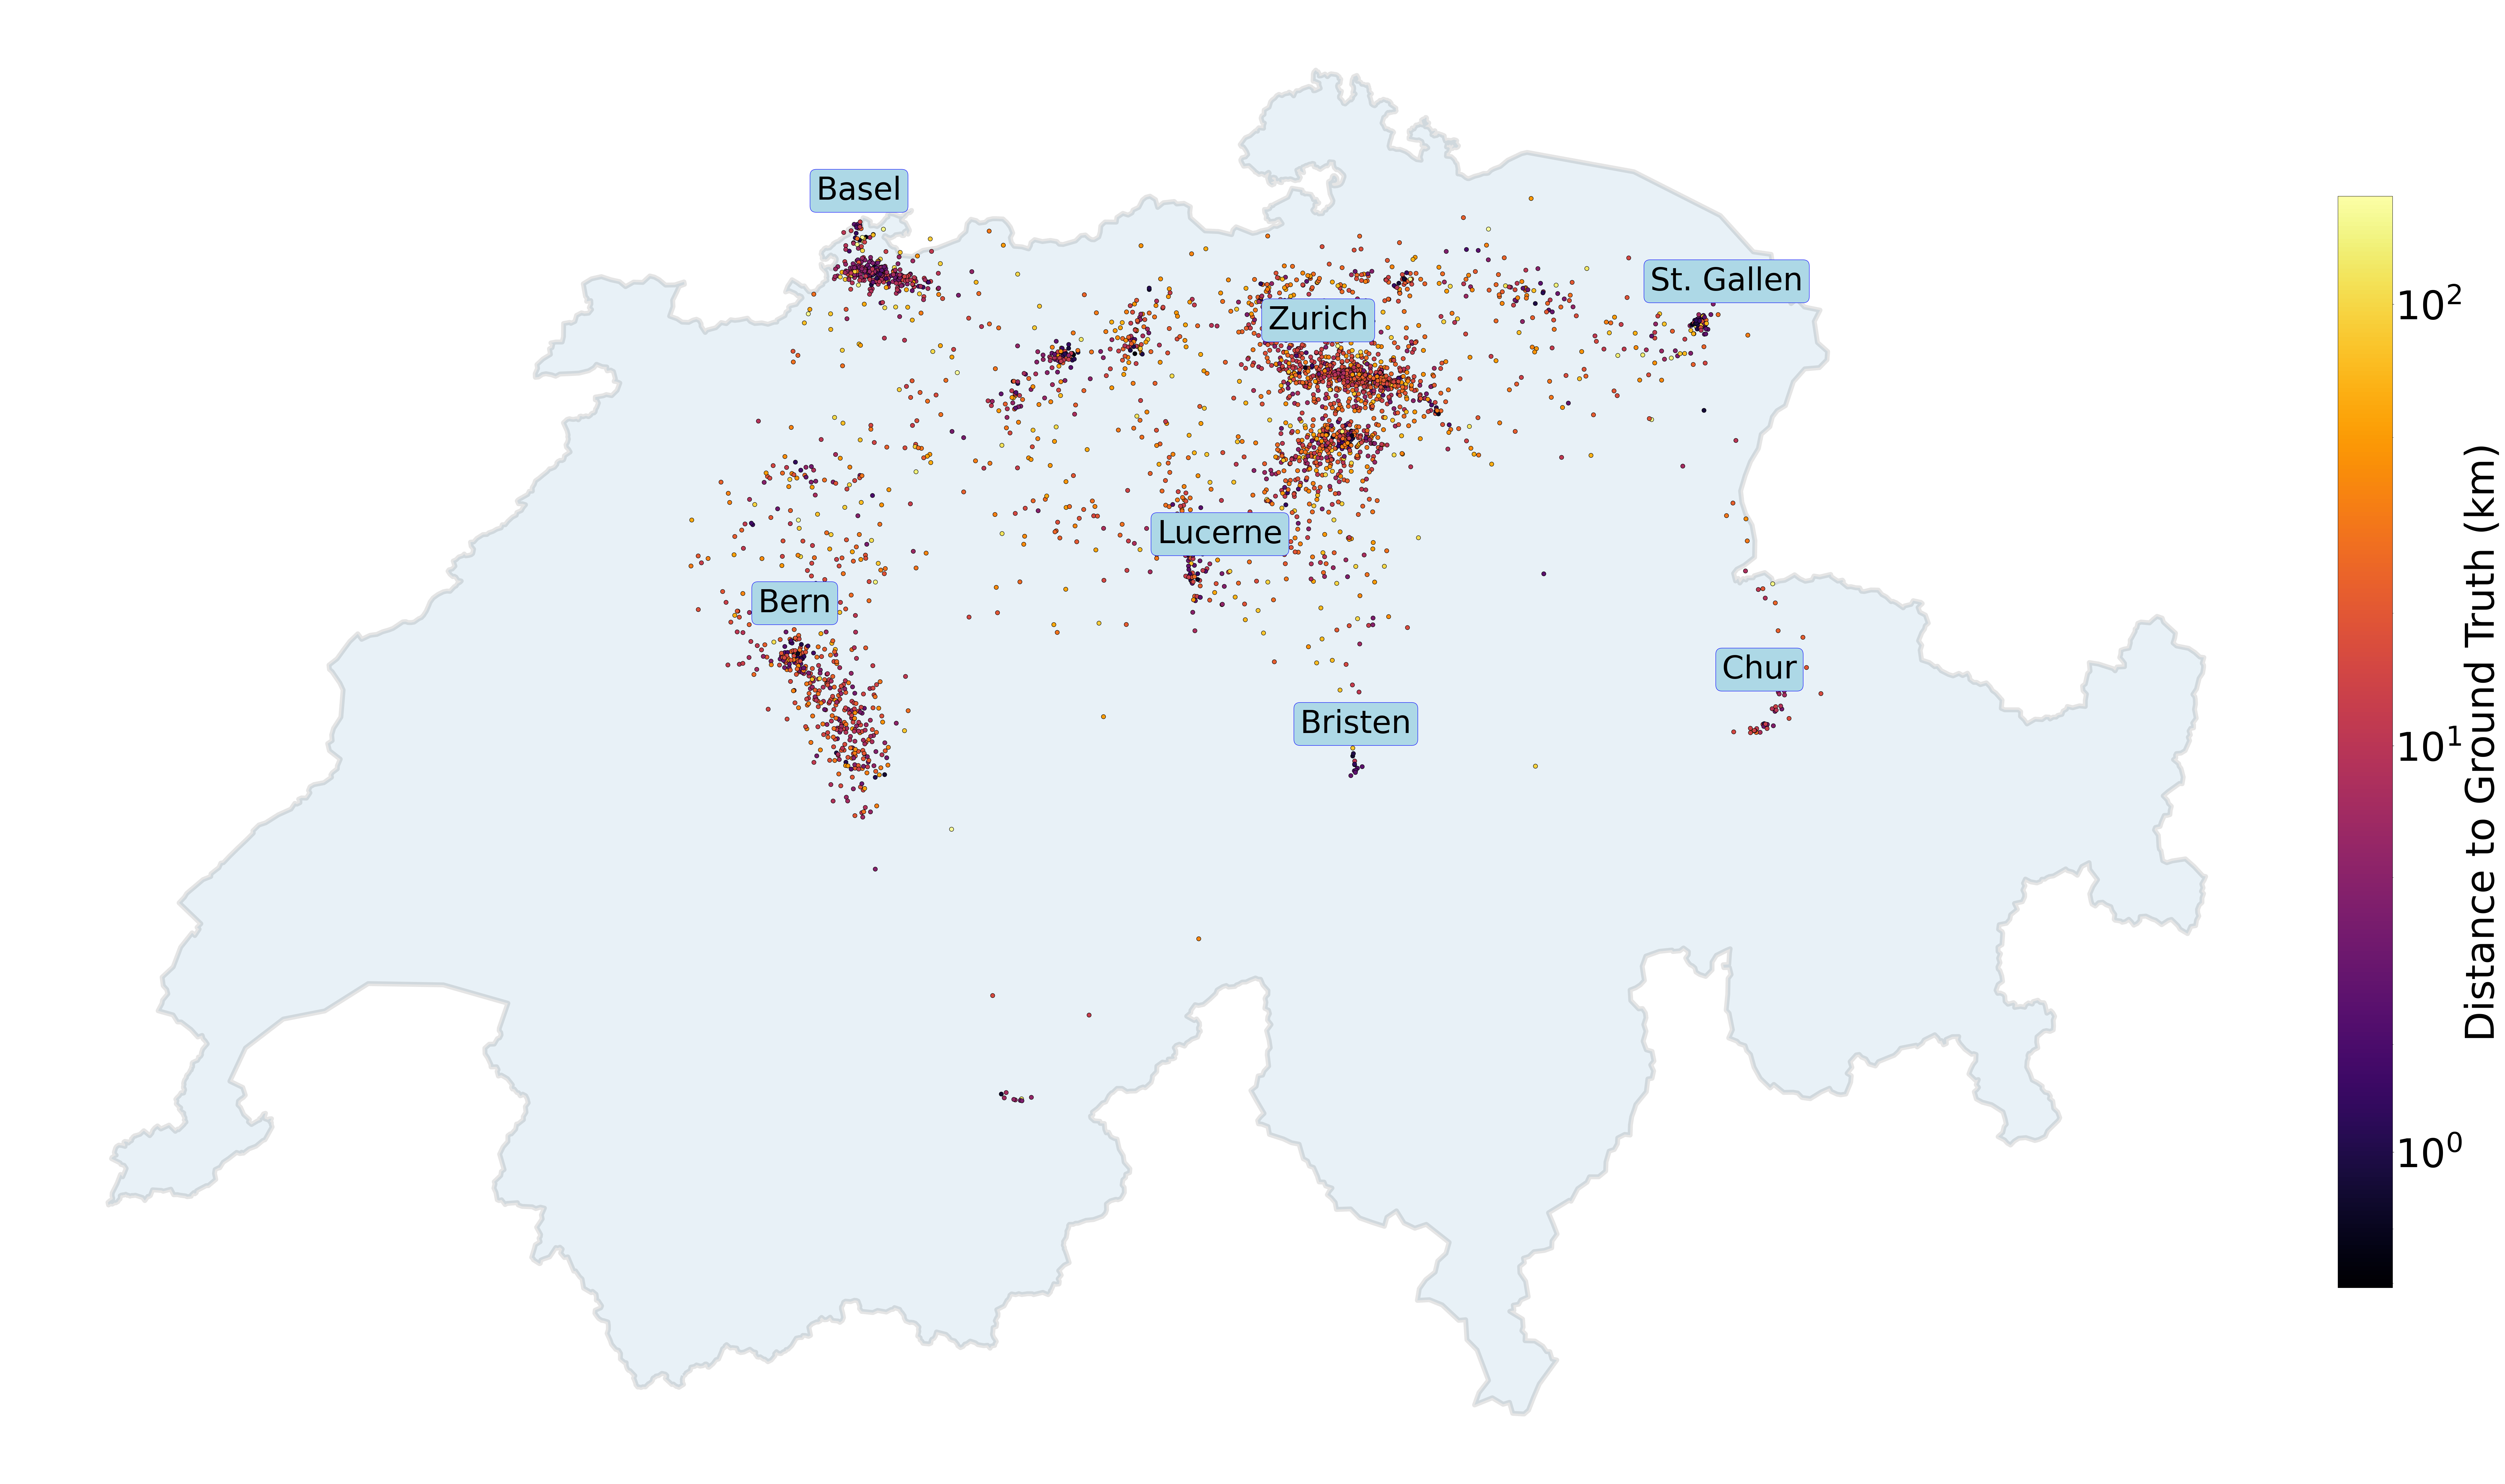

In [7]:
plot_switzerland(test_preds, test_gold_data, data_path)

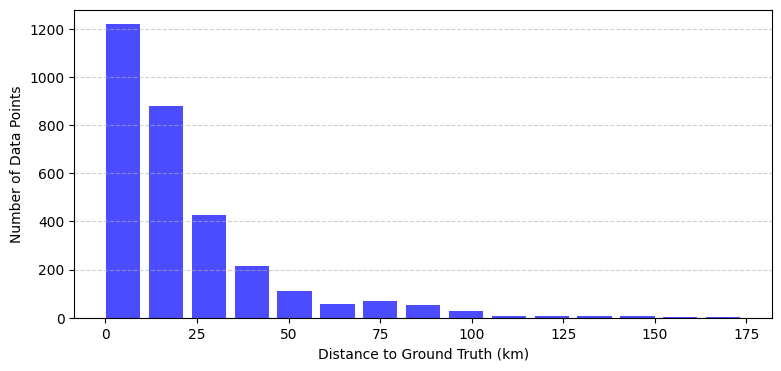

In [13]:
%autoreload 2

plot_barchart(test_preds, test_gold_data)